<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/pairtrading3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyzing forex pairs from 2023-01-01 to 2025-03-05


[*********************100%***********************]  47 of 47 completed
<ipython-input-3-1280f5ecbc5d>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')



Analyzing 1081 possible pairs...

Found 295 significant pairs (p < 0.05):

Top Cointegrated Pairs:
Pair 1     Pair 2     P-Value    Hedge Ratio  Half-Life 
------------------------------------------------------------
EURGBP     GBPDKK     0.0000    -0.0980      0.7


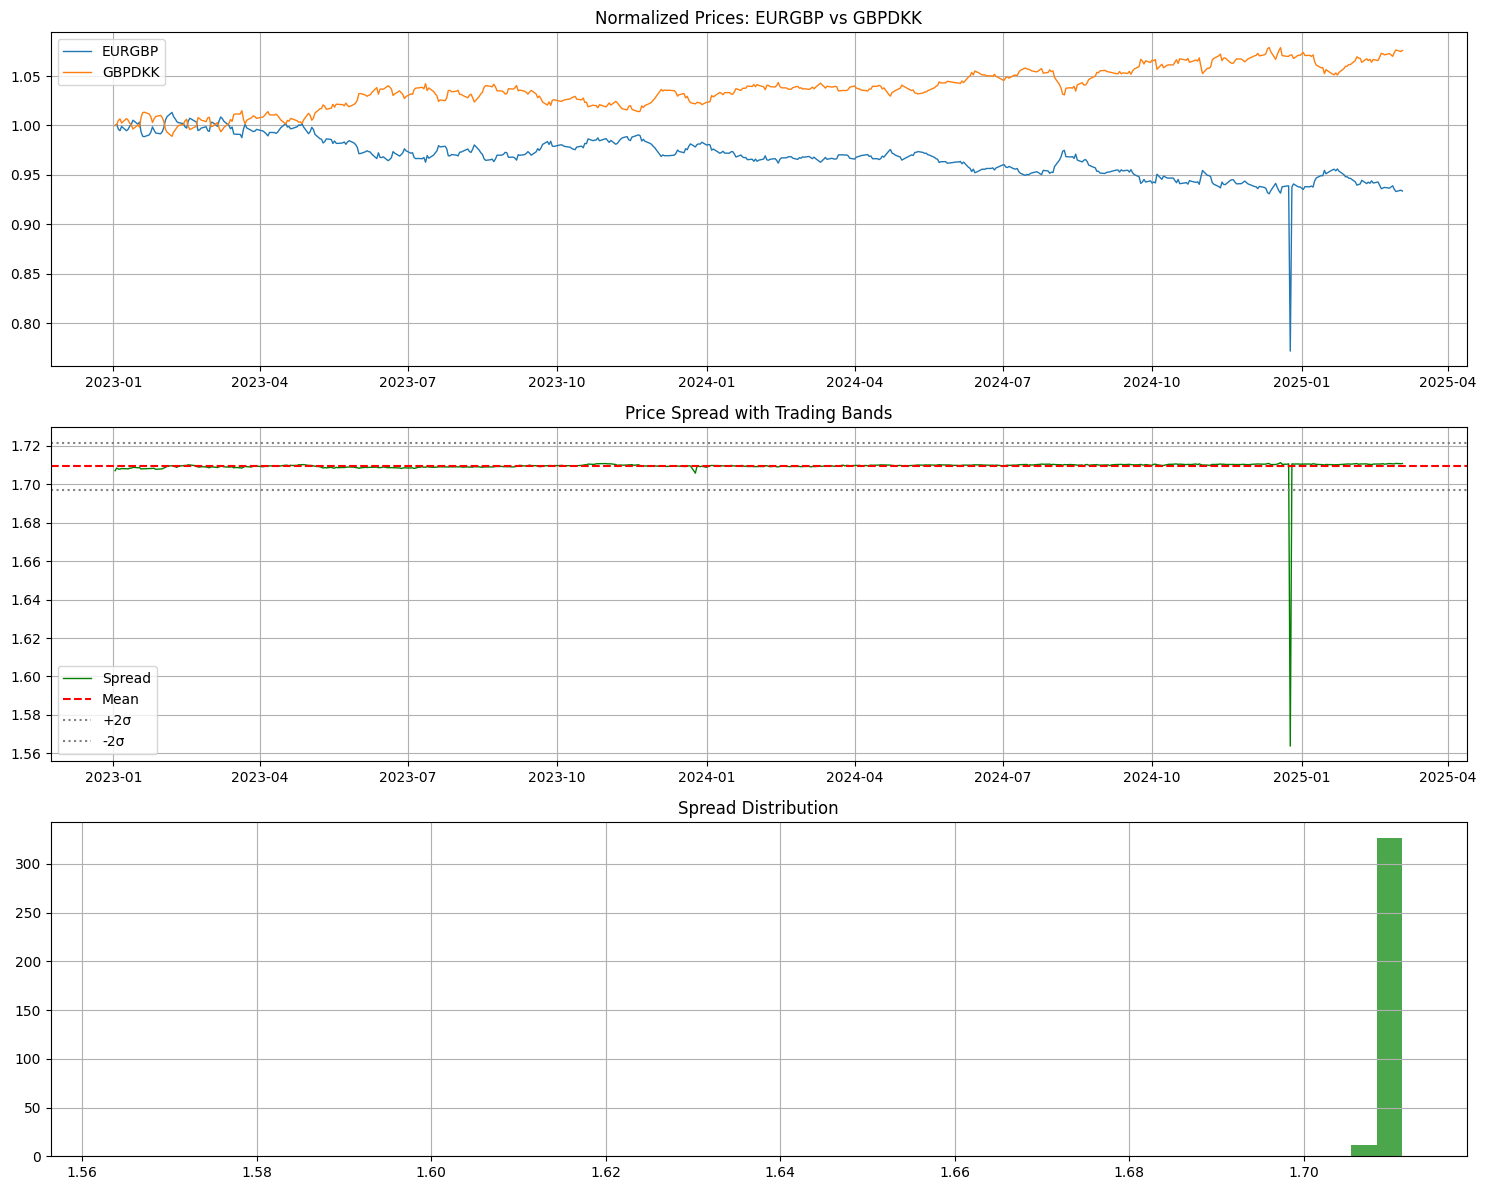

EURNZD     GBPAUD     0.0000    0.5784      10.3


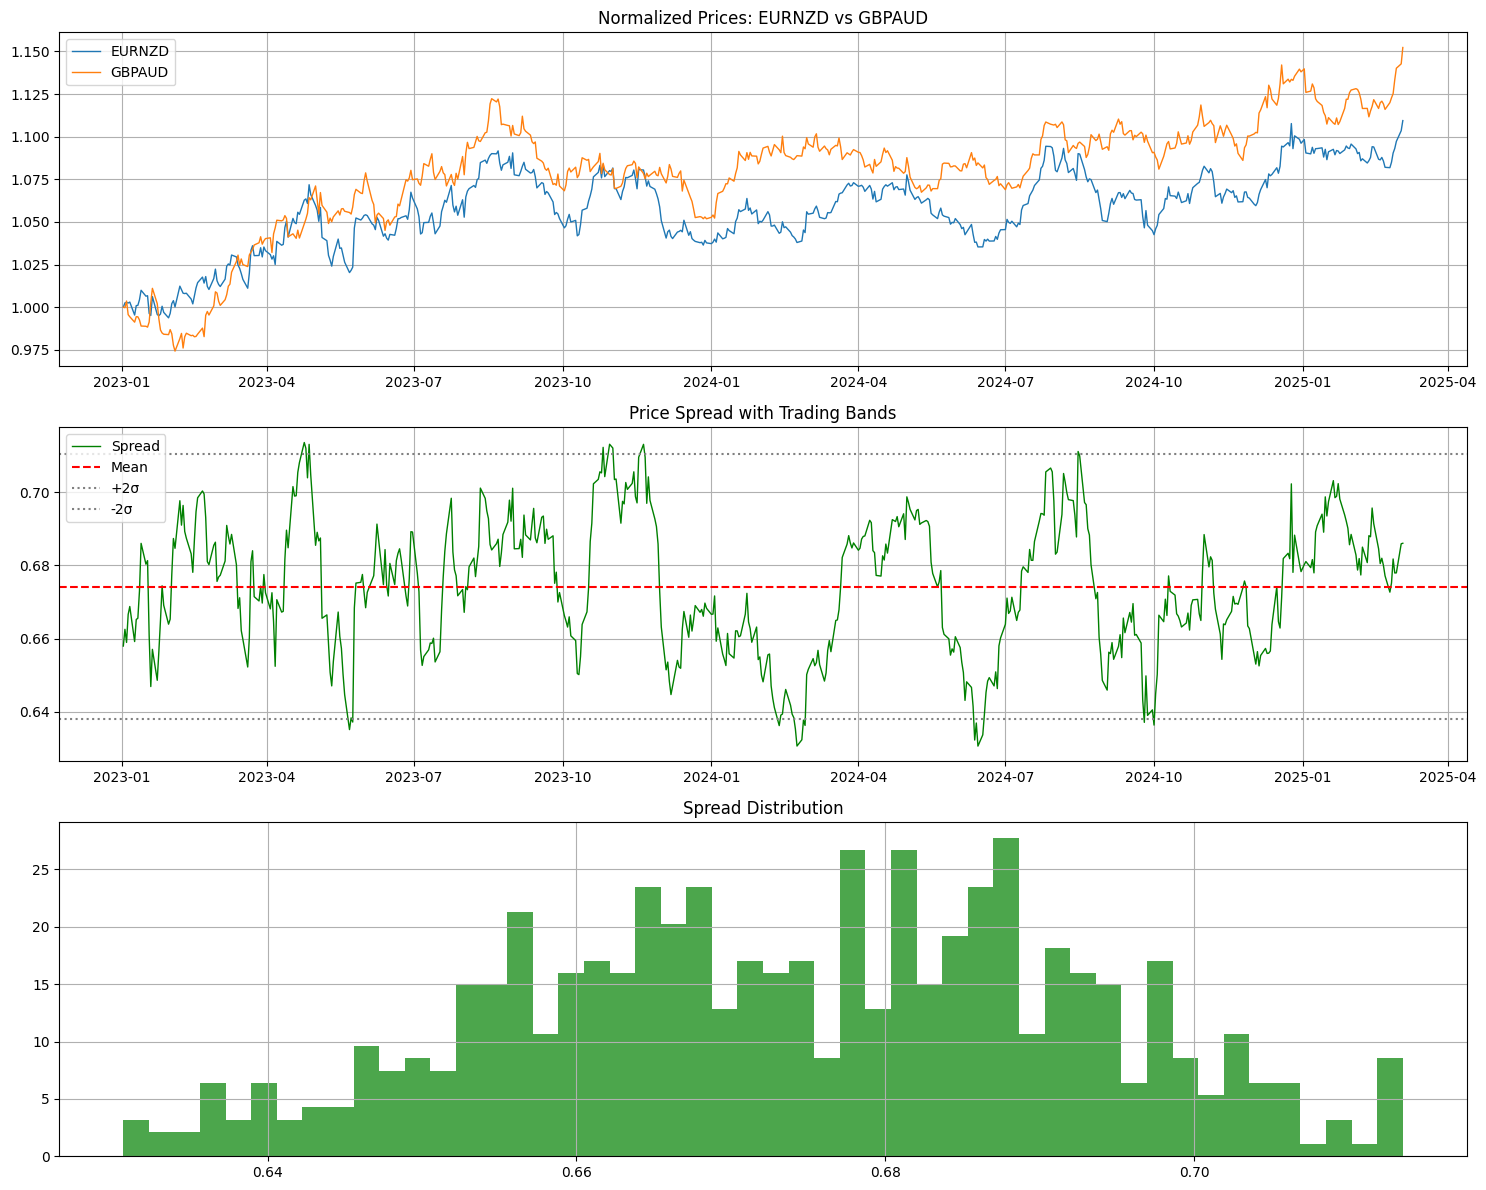

GBPCAD     USDHKD     0.0001    -1.7945      13.1


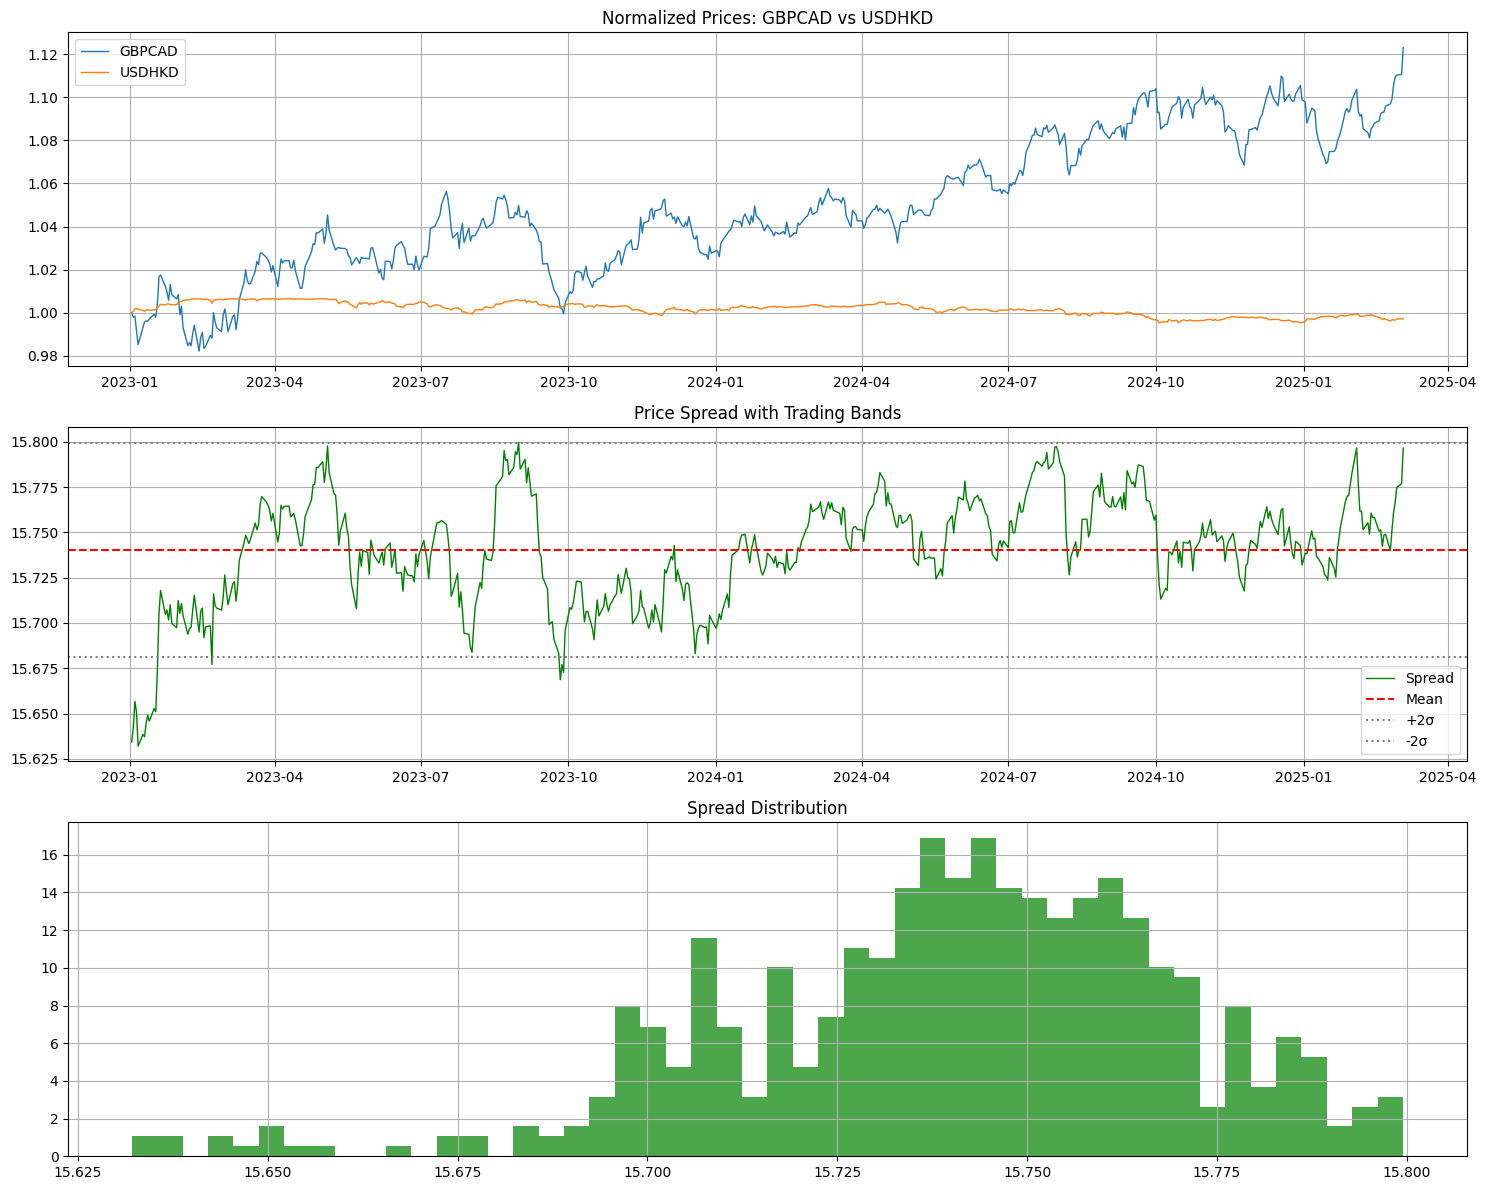

GBPDKK     USDHKD     0.0001    -5.9511      11.1


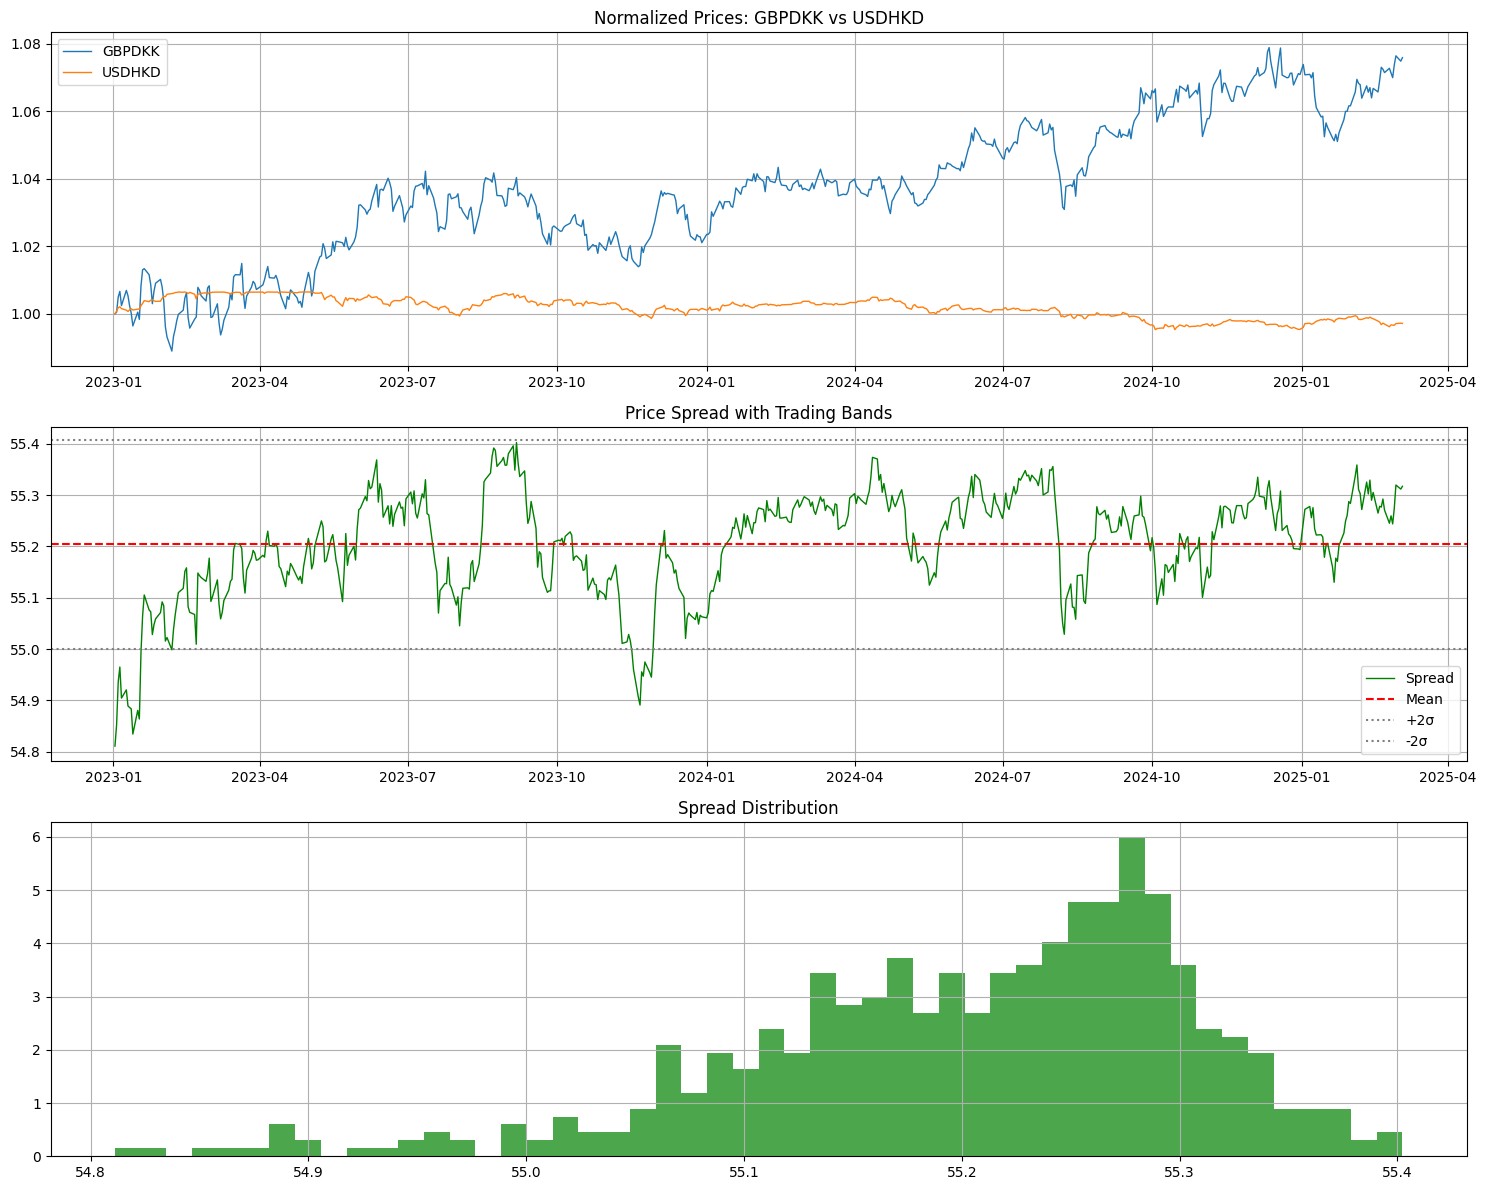

DKKJPY     EURJPY     0.0001    0.1324      0.8


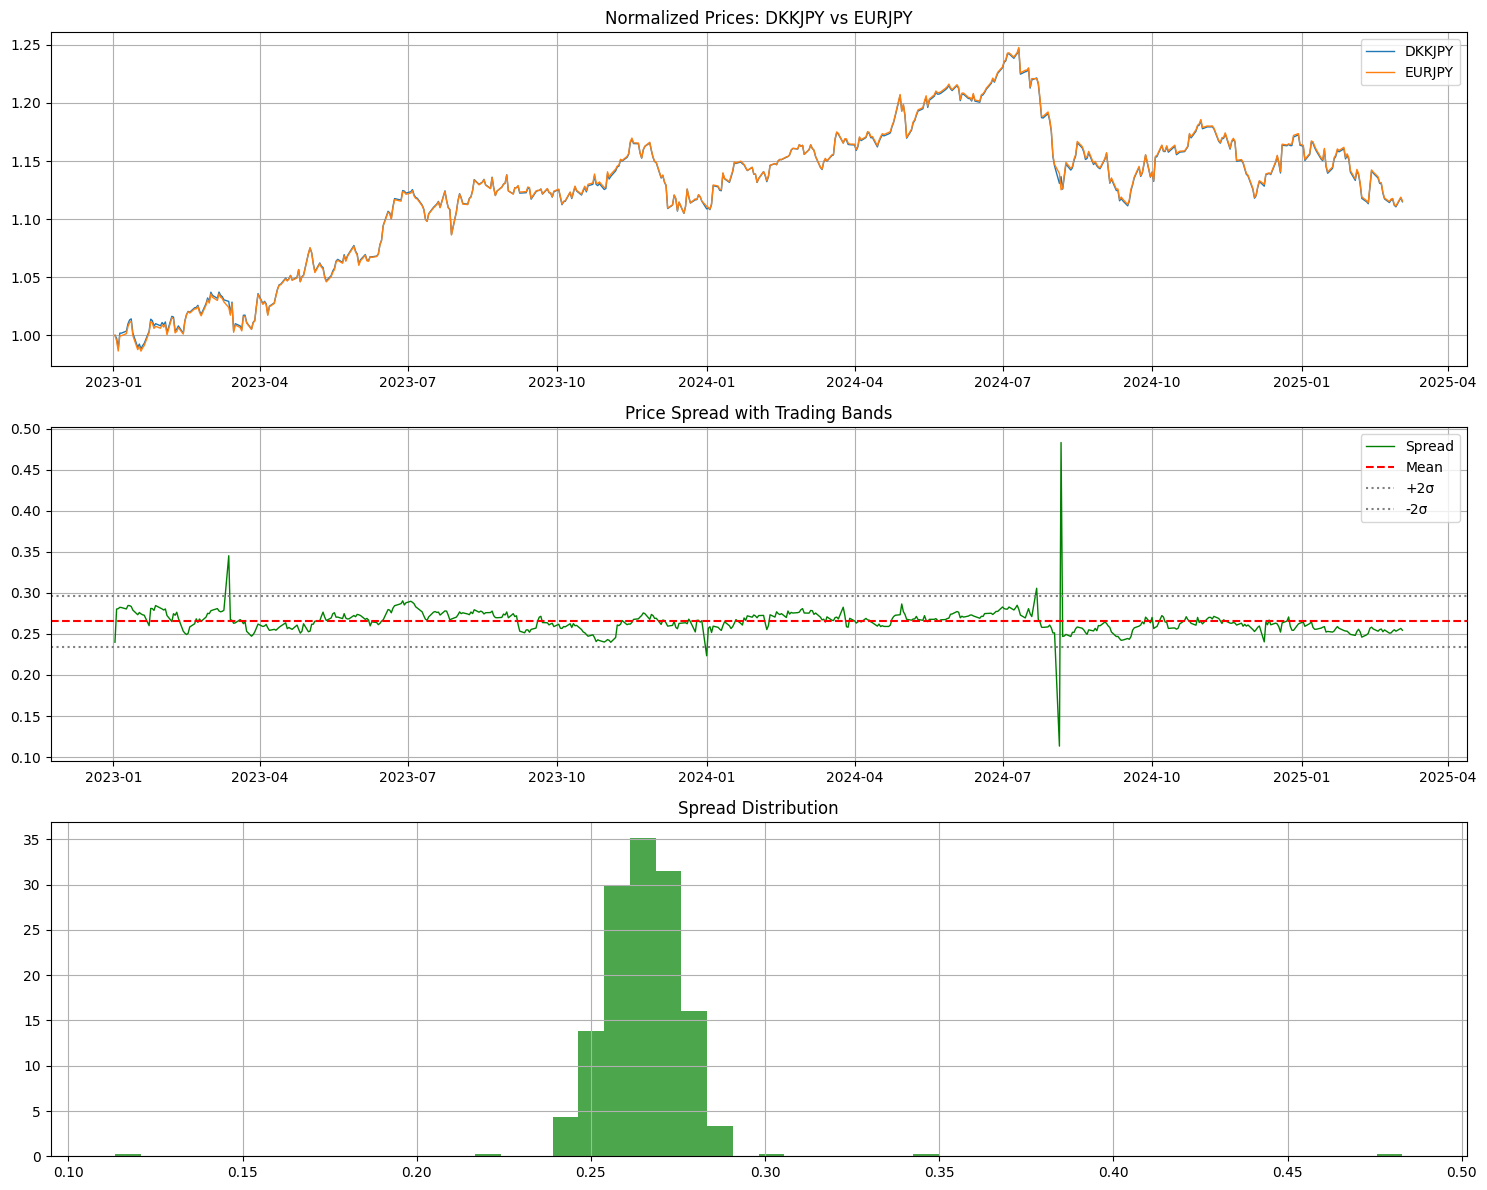

EURGBP     USDHKD     0.0001    0.5882      2.1
EURGBP     GBPCAD     0.0001    -0.3034      1.4
GBPNOK     USDHKD     0.0001    -14.6876      15.0
EURCAD     GBPCAD     0.0003    0.3458      10.4
EURGBP     GBPNZD     0.0004    -0.1946      1.6

Detailed results saved to 'forex_pairs_analysis.csv'


In [3]:
!pip install --upgrade yfinance

import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import itertools
import matplotlib.pyplot as plt
from datetime import datetime

# Define major and minor forex pairs
forex_pairs = [
    # Major pairs
    'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'USDCAD=X', 'NZDUSD=X',
    # Minor pairs
    'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURCAD=X', 'EURNZD=X',
    'GBPJPY=X', 'GBPCHF=X', 'GBPAUD=X', 'GBPCAD=X', 'GBPNZD=X',
    'CHFJPY=X', 'AUDJPY=X', 'CADJPY=X', 'NZDJPY=X',
    # Exotic pairs
    'USDSEK=X', 'USDNOK=X', 'USDDKK=X', 'USDSGD=X', 'USDHKD=X',
    'EURHUF=X', 'EURPLN=X', 'EURCZK=X', 'EURTRY=X', 'EURSEK=X',
    'GBPSEK=X', 'GBPNOK=X', 'GBPDKK=X', 'GBPSGD=X', 'GBPHKD=X',
    'AUDNZD=X', 'AUDCHF=X', 'AUDCAD=X', 'CADCHF=X', 'NZDCHF=X',
    'SGDJPY=X', 'SEKJPY=X', 'NOKJPY=X', 'DKKJPY=X', 'ZARJPY=X'
]

def download_forex_data(pairs, start_date, end_date):
    """
    Download forex data from Yahoo Finance
    """
    try:
#        data = yf.download(pairs, start=start_date, end=end_date)['Adj Close']
        data = yf.download(pairs, start=start_date, end=end_date)['Close']
        data = data.fillna(method='ffill')
        # Remove pairs with too many missing values
        missing_threshold = len(data) * 0.1  # 10% missing data threshold
        data = data.dropna(axis=1, thresh=missing_threshold)
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

def test_cointegration(pair1, pair2, data, significance_level=0.05):
    """
    Test for cointegration between two forex pairs
    Returns: (is_cointegrated, p_value, hedge_ratio, half_life)
    """
    try:
        # Calculate the optimal hedge ratio using OLS
        Y = data[pair1].values
        X = data[pair2].values
        X = np.vstack([X, np.ones(len(X))]).T
        beta = np.linalg.lstsq(X, Y, rcond=None)[0][0]

        # Calculate the spread
        spread = data[pair1] - beta * data[pair2]

        # Perform ADF test
        result = adfuller(spread.dropna())
        p_value = result[1]

        # Calculate half-life of mean reversion
        spread_lag = spread.shift(1)
        spread_diff = spread - spread_lag
        spread_lag = spread_lag.dropna()
        spread_diff = spread_diff.dropna()

        model = np.polyfit(spread_lag, spread_diff, 1)
        half_life = -np.log(2) / model[0] if model[0] < 0 else np.inf

        return (p_value < significance_level, p_value, beta, half_life)
    except Exception as e:
        print(f"Error in cointegration test for {pair1} and {pair2}: {e}")
        return (False, 1.0, 0, np.inf)

def find_significant_pairs(data, significance_level=0.05):
    """
    Find significantly cointegrated pairs and sort by p-value
    """
    pairs = list(itertools.combinations(data.columns, 2))
    significant_pairs = []

    print(f"\nAnalyzing {len(pairs)} possible pairs...")

    for pair in pairs:
        pair1, pair2 = pair
        is_cointegrated, p_value, hedge_ratio, half_life = test_cointegration(
            pair1, pair2, data, significance_level
        )

        if is_cointegrated and half_life != np.inf and half_life > 0:
            significant_pairs.append({
                'pair1': pair1.replace('=X', ''),
                'pair2': pair2.replace('=X', ''),
                'p_value': p_value,
                'hedge_ratio': hedge_ratio,
                'half_life': half_life
            })

    # Sort by p-value (strongest cointegration first)
    return sorted(significant_pairs, key=lambda x: x['p_value'])

def plot_pair_analysis(data, pair_info):
    """
    Create detailed analysis plot for a pair
    """
    pair1 = pair_info['pair1'] + '=X'
    pair2 = pair_info['pair2'] + '=X'
    hedge_ratio = pair_info['hedge_ratio']

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

    # Plot 1: Normalized prices
    norm1 = data[pair1] / data[pair1].iloc[0]
    norm2 = data[pair2] / data[pair2].iloc[0]
    ax1.plot(norm1, label=pair_info['pair1'], linewidth=1)
    ax1.plot(norm2, label=pair_info['pair2'], linewidth=1)
    ax1.set_title(f'Normalized Prices: {pair_info["pair1"]} vs {pair_info["pair2"]}')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Spread
    spread = data[pair1] - hedge_ratio * data[pair2]
    ax2.plot(spread, label='Spread', color='green', linewidth=1)
    ax2.axhline(y=spread.mean(), color='r', linestyle='--', label='Mean')
    ax2.axhline(y=spread.mean() + 2*spread.std(), color='gray', linestyle=':', label='+2σ')
    ax2.axhline(y=spread.mean() - 2*spread.std(), color='gray', linestyle=':', label='-2σ')
    ax2.set_title('Price Spread with Trading Bands')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Spread distribution
    ax3.hist(spread, bins=50, density=True, alpha=0.7, color='green')
    ax3.set_title('Spread Distribution')
    ax3.grid(True)

    plt.tight_layout()
    return fig

def main():
    # Set time period
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = '2023-01-01'  # One year of data

    print(f"Analyzing forex pairs from {start_date} to {end_date}")

    # Download data
    data = download_forex_data(forex_pairs, start_date, end_date)

    if data is not None:
        # Find significant pairs
        significant_pairs = find_significant_pairs(data)

        # Display results
        print(f"\nFound {len(significant_pairs)} significant pairs (p < 0.05):")
        print("\nTop Cointegrated Pairs:")
        print(f"{'Pair 1':<10} {'Pair 2':<10} {'P-Value':<10} {'Hedge Ratio':<12} {'Half-Life':<10}")
        print("-" * 60)

        # Show top 10 pairs with lowest p-values
        for pair in significant_pairs[:10]:
            print(f"{pair['pair1']:<10} {pair['pair2']:<10} {pair['p_value']:.4f}    {pair['hedge_ratio']:.4f}      {pair['half_life']:.1f}")

            # Create detailed analysis plot for top 5 pairs
            if significant_pairs.index(pair) < 5:
                fig = plot_pair_analysis(data, pair)
                plt.show()

        # Save results to CSV
        results_df = pd.DataFrame(significant_pairs)
        results_df.to_csv('forex_pairs_analysis.csv', index=False)
        print("\nDetailed results saved to 'forex_pairs_analysis.csv'")

if __name__ == "__main__":
    main()